In [3]:
out_dir = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/ccm_memory/results/notebook_02'

# 01 - Get Datasets


**Data will be Imported from a CSV which is expected to be in this format**
- sub column contents MUST match the names of the neuroimaging files above. 
    - ID column 
```
+-----+----------------------------+--------------+--------------+--------------+
| sub | Nifti_File_Path            | Indep. Var.  | Covariate_N  | Dataset      |
+-----+----------------------------+--------------+--------------+--------------+
| 1   | /path/to/file1.nii.gz      | 0.5          | 1.2          | 1            |
| 2   | /path/to/file2.nii.gz      | 0.7          | 1.4          | 1            |
| 3   | /path/to/file3.nii.gz      | 0.6          | 1.5          | 2            |
| 4   | /path/to/file4.nii.gz      | 0.9          | 1.1          | 3            |
| ... | ...                        | ...          | ...          | ...          |
+-----+----------------------------+--------------+--------------+--------------+
```

In [2]:
input_csv_path = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/ccm_memory/metadata/master_list_v3.csv'
sheet = None # Set to None if CSV

In [ ]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# Instantiate the PalmPrepararation class
cal_palm = CalvinStatsmodelsPalm(input_csv_path=input_csv_path, output_dir=out_dir, sheet=sheet)
# Call the process_nifti_paths method
data_df = cal_palm.read_and_display_data()
display(data_df)

**Handle NANs**
- Set drop_nans=True is you would like to remove NaNs from data
- Provide a column name or a list of column names to remove NaNs from

In [11]:
drop_list = ['Nifti_File_Path', 'diagnosis']

In [ ]:
data_df = cal_palm.drop_nans_from_columns(columns_to_drop_from=drop_list)
display(data_df)

**Drop Row Based on Value of Column**

Define the column, condition, and value for dropping rows
- column = 'your_column_name'
- condition = 'above'  # Options: 'equal', 'above', 'below'

In [17]:
column = 'Dataset'
condition = 'equal'
value = 'adni_memory'

In [ ]:
data_df, other_df = cal_palm.drop_rows_based_on_value(column, condition, value)
data_df

**Standardize Data**
- Enter Columns you Don't want to standardize into a list

In [19]:
# Remove anything you don't want to standardize
cols_not_to_standardize = ['Dataset', 'Subject'] # ['Z_Scored_Percent_Cognitive_Improvement_By_Origin_Group', 'Z_Scored_Subiculum_T_By_Origin_Group_'] #['Age']
group_col = 'Dataset' #Set to none if there are no specific groups

In [ ]:
data_df = cal_palm.standardize_columns(cols_not_to_standardize, group_col)
data_df

# 02 - Import the Data into DataFrames, Control them, and Save them

In [20]:
dataset_col = 'Dataset'
nifti_path_col = 'Nifti_File_Path'
indep_var_col = 'percent_memory_improvement'
covariate_cols = ['diagnosis']

In [ ]:
from calvin_utils.ccm_utils.nifti_utils import DatasetNiftiImporter
data_importer = DatasetNiftiImporter(df=data_df, dataset_col=dataset_col, nifti_col=nifti_path_col, indep_var_col=indep_var_col, covariate_cols=covariate_cols, out_dir=out_dir, regression_method='ols')

# 03 - Begin Analysis

Enter the path to the dictionary generated by Step 2

In [8]:
dict_path = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/ccm_memory/results/notebook_02/tmp/dataset_dict.json'

What correlation method would you like to use?
- Pearson is very fast, but depends on linearity and is sensitive to outliers
- Spearman is slower, but much more robust

In [9]:
correlation = 'pearson'

In [ ]:
from calvin_utils.ccm_utils.npy_utils import DataLoader
from calvin_utils.ccm_utils.stat_utils import CorrelationCalculator
data_loader = DataLoader(dict_path)
correlation_calculator = CorrelationCalculator(method=correlation, verbose=False)
corr_map_dict = correlation_calculator.process_all_datasets(data_loader.dataset_paths_dict)

Generate the Convergent Maps and Save the Individual Correlation Maps

In [ ]:
from calvin_utils.ccm_utils.ccm_utils import ConvergentMapGenerator
convergent_map_generator = ConvergentMapGenerator(corr_map_dict, data_loader, weight=False)
convergent_map_generator.generate_and_save_maps()
convergent_map_generator.save_individual_r_maps()

Test the Convergent Map

In [55]:
from calvin_utils.ccm_utils.ccm_utils import LOOCVAnalyzer
loocv_analyzer = LOOCVAnalyzer(corr_map_dict, data_loader, convergence_type='average', method='pearson', n_bootstrap=1000, out_dir=None)
results = loocv_analyzer.perform_loocv()
display(loocv_analyzer.results_df)

Running bootstraps: 100%|██████████| 1000/1000 [00:00<00:00, 1252.56it/s]


,Dataset,CI Lower,CI Upper,Mean R
0,grafmann_memory,-0.103747,0.148772,0.029552
1,manitoba_memory,-0.352952,0.248251,-0.051475
2,kahana_memory,-0.252510,0.181490,-0.015955
3,queensland_memory,-0.262861,0.248483,0.071129
4,sante_memory,-0.402047,0.130736,-0.095362


Generate a Forest Plot of the Results

Saved to /Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/ccm_memory/results/notebook_02 as meta_convergence_forest_plot.svg and .png


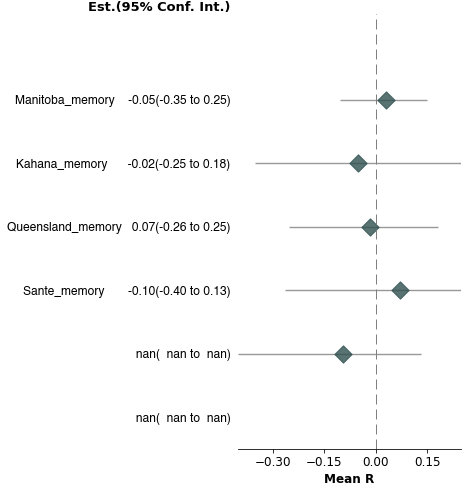

In [ ]:
from calvin_utils.ccm_utils.stat_utils import MetaConvergenceForestPlot
meta_forest_plot = MetaConvergenceForestPlot(loocv_analyzer.results_df, sig_digits=2, out_dir=out_dir, table=True)
meta_forest_plot.run()

That's all
- Calvin